# Resume Training from Checkpoints

In many cases, training a deep neural network from a large dataset will take a long time, maybe even several days.

In order to avoid that we lose all training progress we may have made should something happen during
training (e.g. the computer may crash), we can save checkpoints at regular intervals, e.g. each epoch.

In the case that something goes wrong, we can then resume training from such a checkpoint.

In this case we use again the small Iris dataset as an example and use a simple network.
However, we first train a few iterations and then pretend something has happened - and resume training afterwards
from a checkpoint.

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
import pydot

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.1.0


In [2]:
#load the data
iris = load_iris()

In [3]:
#define the network model
n_input = 4
n_output = 3
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(n_input,)))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(n_output))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


Now we set the model up, define loss function and optimmizers.
We also define the callbacks we want to use. 

In our case, we add the callback that creates checkpoints at the end of each training epoch.
Note that we store the full model, not just the weights. Alternatively, we can also just store the 
weights but then we have to create the exact same model manually if we want to resume training.

In [4]:
# setup the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

callbacks = [
    # write logs to ./logs
    tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))),
    # write checkpoints to ./checkpoints. 
    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model{epoch:02d}.h5', save_weights_only=False, save_freq='epoch'),
]

history = model.fit(
        x=iris.data,
        y=iris.target,
        batch_size=32,
        epochs=5,
        verbose=0,
        callbacks=callbacks
    )

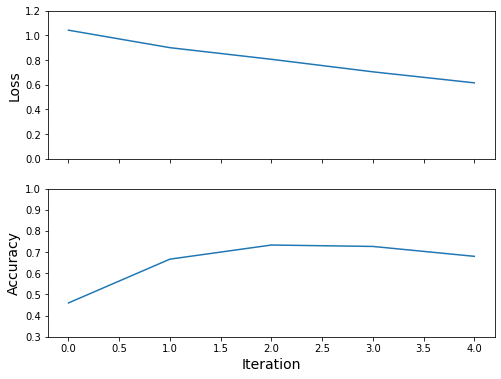

In [23]:
history_dict = history.history
history_dict.keys()
loss_values = history_dict['loss']
acc_values = history_dict['sparse_categorical_accuracy']
epochs = range(1, len(loss_values) + 1)

fig, axes = plt.subplots(2, sharex=True)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(loss_values)
axes[0].set_ylim(0.0,1.2)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].set_ylim(0.3,1.0)
axes[1].plot(acc_values)
plt.show()

We now pretend the computer has crashed after just 5 iterations.
Let's check that the checkpoints are there.
(Note that since we may have run the examples a few times, the old files are there too)

In [6]:
!ls -lat checkpoints

total 1800
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 14:37 model05.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 14:37 model04.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 14:37 model03.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 14:37 model02.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 14:37 model01.h5
drwxrwxrwx 1 kerzel kerzel  4096 May  6 14:36 ..
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model50.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model49.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model48.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model47.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model46.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model45.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model44.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model43.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model42.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model41.h5
-rwxrwxrwx 1 kerzel kerzel 34592 May  6 12:51 model40.h5
-rwxrwxrwx 1 kerzel kerzel 3

We now resume training and restore from a checkpoint.

In [7]:
# use the latest checkpoint and check it's the same as the model we have created originally.
ckpt_model = tf.keras.models.load_model('./checkpoints/model05.h5')
ckpt_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


We can then resume training.
Note that we do have to load the relevant data, etc.
In this example, we continue to use the same callbacks defined above.

We store the training summary in a separate object to be able to look at the resumed
training independently of the first training.

In [8]:
history2 = ckpt_model.fit(
            x=iris.data,
            y=iris.target,
            batch_size=32,
            epochs=45,
            verbose=0,
            callbacks=callbacks
    )

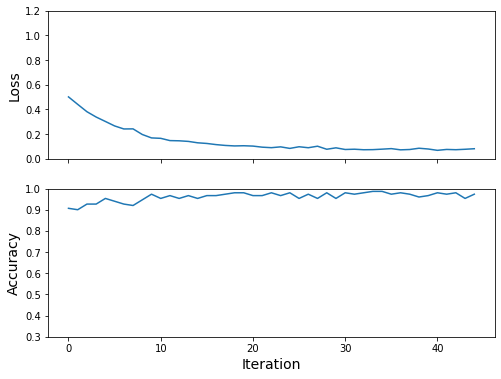

In [24]:
history_dict2 = history2.history
history_dict2.keys()
loss_values = history_dict2['loss']
acc_values = history_dict2['sparse_categorical_accuracy']
epochs = range(1, len(loss_values) + 1)

fig, axes = plt.subplots(2, sharex=True)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(loss_values)
axes[0].set_ylim(0.0,1.2)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].set_ylim(0.3,1.0)
axes[1].plot(acc_values)
plt.show()